**Import & Setup**
---

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import os
import random
import scipy.stats

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import random

!pip install -q mord
import mord

!pip install -q transformers datasets
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machi

In [ ]:
# Load the dataset
df = pd.read_csv("adjudicated.csv")

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into Train (60%), Dev (20%), and Test (20%)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Dev size: {len(dev_df)}, Test size: {len(test_df)}")

Train size: 300, Dev size: 100, Test size: 100


In [ ]:
df.to_csv("adjudicated.txt", sep="\t", index=False, header=False)
train_df.to_csv("train.txt", sep="\t", index=False, header=False)
dev_df.to_csv("dev.txt", sep="\t", index=False, header=False)
test_df.to_csv("test.txt", sep="\t", index=False, header=False)



---



**Majority Classifier**

In [ ]:

#Find the majority class in the training set
majority_label = train_df['label'].mode()[0]
print(f"Majority class label (most frequent): {majority_label}")

#Predict the majority label for dev and test sets
dev_preds_majority = [majority_label] * len(dev_df)
test_preds_majority = [majority_label] * len(test_df)

# Step 3: Evaluate
majority_dev_acc = accuracy_score(dev_df['label'], dev_preds_majority)
majority_test_acc = accuracy_score(test_df['label'], test_preds_majority)

print(f"Majority Classifier Dev Accuracy: {majority_dev_acc:.4f}")
print(f"Majority Classifier Test Accuracy: {majority_test_acc:.4f}")

Majority class label (most frequent): 1
Majority Classifier Dev Accuracy: 0.5200
Majority Classifier Test Accuracy: 0.5200


In [ ]:
def compute_confidence_interval(acc, n, confidence=0.95):
    stderr = np.sqrt((acc * (1 - acc)) / n)
    delta = stderr * scipy.stats.t.ppf((1 + confidence) / 2, n - 1)
    return acc - delta, acc + delta

# Calculate confidence interval
n_test = len(test_df)
majority_ci = compute_confidence_interval(majority_test_acc, n_test)

print(f"Majority Classifier 95% Confidence Interval: ({majority_ci[0]:.4f}, {majority_ci[1]:.4f})")

Majority Classifier 95% Confidence Interval: (0.4209, 0.6191)




---



**Logistic Regression**

In [ ]:
# Feature Engineering (TF-IDF Vectors)
vectorizer = TfidfVectorizer(
    max_features=5000,         # Limit vocabulary size
    ngram_range=(1,2),          # Use unigrams + bigrams
    stop_words='english',       # Remove common stopwords
    lowercase=True              # Lowercase everything
)

# Fit on train set, transform all sets
X_train_tfidf = vectorizer.fit_transform(train_df['original_text'])
X_dev_tfidf = vectorizer.transform(dev_df['original_text'])
X_test_tfidf = vectorizer.transform(test_df['original_text'])

y_train = train_df['label']
y_dev = dev_df['label']
y_test = test_df['label']

print(f"TF-IDF Shape (Train): {X_train_tfidf.shape}")
print(f"TF-IDF Shape (Dev): {X_dev_tfidf.shape}")
print(f"TF-IDF Shape (Test): {X_test_tfidf.shape}")

TF-IDF Shape (Train): (300, 1325)
TF-IDF Shape (Dev): (100, 1325)
TF-IDF Shape (Test): (100, 1325)


In [ ]:
# Train Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_tfidf, y_train)

# Predict
dev_preds_logreg = logreg_model.predict(X_dev_tfidf)
test_preds_logreg = logreg_model.predict(X_test_tfidf)

# Evaluate
logreg_dev_acc = accuracy_score(y_dev, dev_preds_logreg)
logreg_test_acc = accuracy_score(y_test, test_preds_logreg)

print(f"Logistic Regression Dev Accuracy: {logreg_dev_acc:.4f}")
print(f"Logistic Regression Test Accuracy: {logreg_test_acc:.4f}")


Logistic Regression Dev Accuracy: 0.9200
Logistic Regression Test Accuracy: 0.9200


In [ ]:
# Calculate confidence interval
logreg_ci = compute_confidence_interval(logreg_test_acc, n_test)

print(f"Logistic Regression 95% Confidence Interval: ({logreg_ci[0]:.4f}, {logreg_ci[1]:.4f})")

Logistic Regression 95% Confidence Interval: (0.8662, 0.9738)




---



**Ordinal Regression**

In [ ]:
# Train Ordinal Logistic Regression
ordinal_model = mord.LogisticAT(alpha=1.0)
ordinal_model.fit(X_train_tfidf, y_train)

# Predict
dev_preds_ordinal = ordinal_model.predict(X_dev_tfidf)
test_preds_ordinal = ordinal_model.predict(X_test_tfidf)

# Evaluate
ordinal_dev_acc = accuracy_score(y_dev, dev_preds_ordinal)
ordinal_test_acc = accuracy_score(y_test, test_preds_ordinal)

print(f"Ordinal Regression Dev Accuracy: {ordinal_dev_acc:.4f}")
print(f"Ordinal Regression Test Accuracy: {ordinal_test_acc:.4f}")

Ordinal Regression Dev Accuracy: 0.9600
Ordinal Regression Test Accuracy: 0.9500


In [ ]:
# Calculate confidence interval
ordinal_ci = compute_confidence_interval(ordinal_test_acc, n_test)

print(f"Ordinal Regression 95% Confidence Interval: ({ordinal_ci[0]:.4f}, {ordinal_ci[1]:.4f})")

Ordinal Regression 95% Confidence Interval: (0.9068, 0.9932)




---



**BERT Fine Tuning**

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load BERT model for 3 classes
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Adjust labels for BERT: shift by -1
train_df['bert_label'] = train_df['label'] - 1
dev_df['bert_label'] = dev_df['label'] - 1
test_df['bert_label'] = test_df['label'] - 1

# Now map for Huggingface datasets
train_ds = Dataset.from_pandas(train_df[['original_text', 'bert_label']])
dev_ds = Dataset.from_pandas(dev_df[['original_text', 'bert_label']])
test_ds = Dataset.from_pandas(test_df[['original_text', 'bert_label']])

# Tokenize same as before
def tokenize_function(examples):
    return tokenizer(examples['original_text'], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize_function, batched=True)
dev_ds = dev_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

train_ds = train_ds.rename_column("bert_label", "labels")
dev_ds = dev_ds.rename_column("bert_label", "labels")
test_ds = test_ds.rename_column("bert_label", "labels")

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
dev_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    seed=42,
    save_steps=50,
    save_total_limit=1
)

# Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    tokenizer=tokenizer
)

# Fine-tune
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-22-8184f8f6d27c>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.163200
20,0.548600
30,0.380200
40,0.254500
50,0.192400
60,0.127100
70,0.091800
80,0.054100
90,0.085000
100,0.067400


Step,Training Loss
10,1.163200
20,0.548600
30,0.380200
40,0.254500
50,0.192400
60,0.127100
70,0.091800
80,0.054100
90,0.085000
100,0.067400


TrainOutput(global_step=114, training_loss=0.26669274335890486, metrics={'train_runtime': 2716.8897, 'train_samples_per_second': 0.331, 'train_steps_per_second': 0.042, 'total_flos': 118401037977600.0, 'train_loss': 0.26669274335890486, 'epoch': 3.0})

In [ ]:
# Predict on test set
predictions = trainer.predict(test_ds)
test_preds_bert = predictions.predictions.argmax(axis=1)

predictions = trainer.predict(dev_ds)
dev_preds_bert = predictions.predictions.argmax(axis=1)

# Evaluate
bert_test_acc = accuracy_score(test_df['label']-1, test_preds_bert)
bert_dev_acc = accuracy_score(dev_df['label']-1, dev_preds_bert)
print(f"BERT Test Accuracy: {bert_test_acc:.4f}")
print(f"BERT Dev Accuracy: {bert_test_acc:.4f}")

BERT Test Accuracy: 0.9900
BERT Dev Accuracy: 0.9900


In [ ]:
bert_ci = compute_confidence_interval(bert_test_acc, n_test)

print(f"BERT 95% Confidence Interval: ({bert_ci[0]:.4f}, {bert_ci[1]:.4f})")

BERT 95% Confidence Interval: (0.9703, 1.0097)




---

In [ ]:
# summary table
results_summary = pd.DataFrame({
    "Model": [
        "Majority Classifier",
        "Logistic Regression (TF-IDF)",
        "Ordinal Regression (TF-IDF)",
        "BERT Fine-Tuning"
    ],
    "Dev Accuracy": [
        0.5200,
        0.9200,
        0.9600,
        0.9900
    ],
    "Test Accuracy": [
        0.5200,
        0.9200,
        0.9500,
        0.9900
    ],
    "95% Confidence Interval": [
        "(0.4209, 0.6191)",
        "(0.8662, 0.9738)",
        "(0.9068, 0.9932)",
        "(0.9703, 1.0097)"
    ]
})
results_summary

,Model,Dev Accuracy,Test Accuracy,95% Confidence Interval
0,Majority Classifier,0.52,0.52,"(0.4209, 0.6191)"
1,Logistic Regression (TF-IDF),0.92,0.92,"(0.8662, 0.9738)"
2,Ordinal Regression (TF-IDF),0.96,0.95,"(0.9068, 0.9932)"
3,BERT Fine-Tuning,0.99,0.99,"(0.9703, 1.0097)"




---



**Confusion Matrix**

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, title, label_shift=0):
    """Plot confusion matrix, fixing label shifts if needed."""
    if label_shift != 0:
        predicted_labels = predicted_labels + label_shift

    cm = confusion_matrix(true_labels, predicted_labels, labels=[1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3])
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

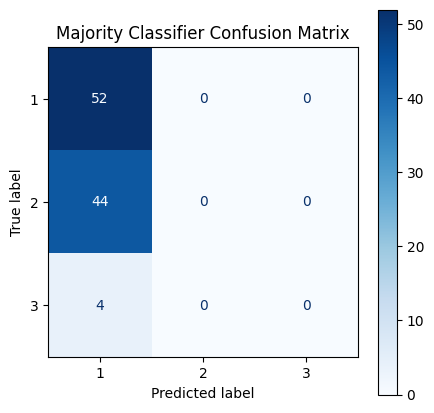

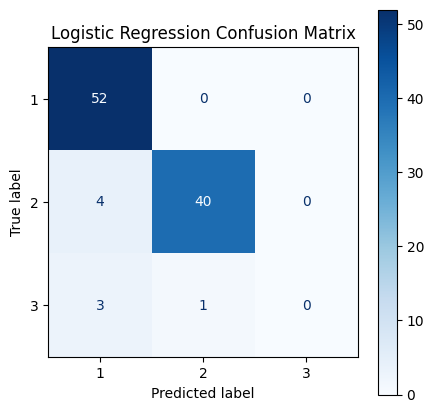

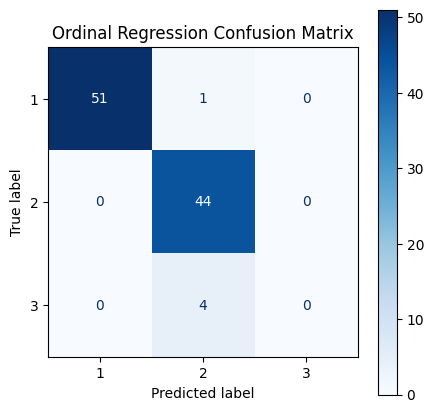

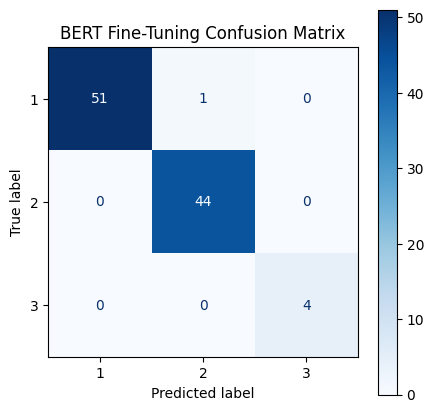

In [ ]:
# Majority Classifier
plot_confusion_matrix(test_df['label'], test_preds_majority, title="Majority Classifier Confusion Matrix")

# Logistic Regression
plot_confusion_matrix(test_df['label'], test_preds_logreg, title="Logistic Regression Confusion Matrix")

# Ordinal Regression
plot_confusion_matrix(test_df['label'], test_preds_ordinal, title="Ordinal Regression Confusion Matrix")

# BERT (shift predictions back +1)
plot_confusion_matrix(test_df['label'], test_preds_bert, title="BERT Fine-Tuning Confusion Matrix", label_shift=1)



---



**Top Errors**

In [ ]:
def get_wrong_predictions(true_labels, predicted_labels, original_texts, label_shift=0, num_samples=5, model_name="Model"):
    """Print wrong predictions."""
    if label_shift != 0:
        predicted_labels = predicted_labels + label_shift

    wrong_indices = [i for i in range(len(true_labels)) if true_labels.iloc[i] != predicted_labels[i]]

    if len(wrong_indices) == 0:
        print(f"No errors found for {model_name}!")
        return

    sampled_wrong_indices = random.sample(wrong_indices, min(num_samples, len(wrong_indices)))

    print(f"\n--- {model_name} - Top {len(sampled_wrong_indices)} Errors ---")
    for idx in sampled_wrong_indices:
        print(f"\nText: {original_texts.values[idx]}")
        print(f"True Label: {true_labels.iloc[idx]}")
        print(f"Predicted Label: {predicted_labels[idx]}")

In [ ]:
# Majority Classifier
get_wrong_predictions(test_df['label'], test_preds_majority, test_df['original_text'], model_name="Majority Classifier")

# Logistic Regression
get_wrong_predictions(test_df['label'], test_preds_logreg, test_df['original_text'], model_name="Logistic Regression")

# Ordinal Regression
get_wrong_predictions(test_df['label'], test_preds_ordinal, test_df['original_text'], model_name="Ordinal Regression")

# BERT (shift predictions back +1)
get_wrong_predictions(test_df['label'], test_preds_bert, test_df['original_text'], label_shift=1, model_name="BERT Fine-Tuning")


--- Majority Classifier - Top 5 Errors ---

Text: We updated our product packaging to include a green leaf symbol that reflects our vision for environmentally mindful living. We aim to increase awareness among customers
True Label: 2
Predicted Label: 1

Text: Plans are underway to transition to manufacturing models across key departments by 2019.
True Label: 2
Predicted Label: 1

Text: Our team is in the early phases of implementing sustainable manufacturing practices, with initial feedback being collected.
True Label: 2
Predicted Label: 1

Text: Plans are underway to transition to supply chain models across key departments by 2019.
True Label: 2
Predicted Label: 1

Text: We are collaborating with EcoCert to evaluate opportunities for product design enhancement, with progress reports expected in 2022.
True Label: 2
Predicted Label: 1

--- Logistic Regression - Top 5 Errors ---

Text: Our operations are guided by green principles and a deep respect for the Earth.
True Label: 3
Predicte



---



**Feature Importance**

In [ ]:
def show_top_features(model, vectorizer, label_id, label_name, top_n=10):
    """Show top positive features for a given label."""
    feature_names = np.array(vectorizer.get_feature_names_out())
    coef = model.coef_[label_id]
    top_positive_indices = np.argsort(coef)[-top_n:]
    top_negative_indices = np.argsort(coef)[:top_n]

    print(f"\n--- Top {top_n} features predicting {label_name} (positively) ---")
    for idx in reversed(top_positive_indices):
        print(f"{feature_names[idx]} ({coef[idx]:.4f})")

    print(f"\n--- Top {top_n} features predicting against {label_name} (negatively) ---")
    for idx in top_negative_indices:
        print(f"{feature_names[idx]} ({coef[idx]:.4f})")

def show_top_features_ordinal(model, vectorizer, top_n=10):
    """Show top positive and negative features for ordinal regression."""
    feature_names = np.array(vectorizer.get_feature_names_out())
    coef = model.coef_  # Already 1D

    top_positive_indices = np.argsort(coef)[-top_n:]
    top_negative_indices = np.argsort(coef)[:top_n]

    print(f"\n--- Top {top_n} features predicting Higher Labels (e.g., Greenwashing) ---")
    for idx in reversed(top_positive_indices):
        print(f"{feature_names[idx]} ({coef[idx]:.4f})")

    print(f"\n--- Top {top_n} features predicting Lower Labels (e.g., Genuine) ---")
    for idx in top_negative_indices:
        print(f"{feature_names[idx]} ({coef[idx]:.4f})")

In [ ]:
# Logistic Regression Important Features
print("\n Logistic Regression Important Features")
show_top_features(logreg_model, vectorizer, label_id=0, label_name="Genuine (Label 1)")
show_top_features(logreg_model, vectorizer, label_id=1, label_name="Mixed (Label 2)")
show_top_features(logreg_model, vectorizer, label_id=2, label_name="Greenwashing (Label 3)")

# Ordinal Regression Important Features
print("\n Ordinal Regression Important Features")
show_top_features_ordinal(ordinal_model, vectorizer)


 Logistic Regression Important Features

--- Top 10 features predicting Genuine (Label 1) (positively) ---
verified (1.1811)
000 (0.9459)
results (0.8266)
consumption (0.5928)
results verified (0.5702)
upgrades cut (0.5702)
cut resource (0.5702)
cut (0.5702)
resource consumption (0.5702)
upgrades (0.5702)

--- Top 10 features predicting against Genuine (Label 1) (negatively) ---
expected (-0.6812)
opportunities (-0.5115)
project improve (-0.5108)
improve (-0.5108)
currently piloting (-0.5108)
targeting (-0.5108)
currently (-0.5108)
piloting (-0.5108)
piloting project (-0.5108)
collaborating (-0.4709)

--- Top 10 features predicting Mixed (Label 2) (positively) ---
expected (0.9484)
currently (0.6946)
currently piloting (0.6946)
targeting (0.6946)
project improve (0.6946)
improve (0.6946)
piloting (0.6946)
piloting project (0.6946)
progress (0.6679)
project (0.6584)

--- Top 10 features predicting against Mixed (Label 2) (negatively) ---
verified (-0.7976)
000 (-0.6403)
results (-0.560



---



**Class Distribution**

In [ ]:
print("\n Test Set Class Distribution")
print(test_df['label'].value_counts().sort_index())

print("\n Training Set Class Distribution")
print(train_df['label'].value_counts().sort_index())


 Test Set Class Distribution
label
1    52
2    44
3     4
Name: count, dtype: int64

 Training Set Class Distribution
label
1    182
2    101
3     17
Name: count, dtype: int64




---



**Interpretation**

**Confusion Matrices Interpretation**

The confusion matrices across the four models reveal clear trends.
*   The Majority Classifier predicts a single label for all instances leading to poor generalization.
*   Logistic Regression and Ordinal Regression show stronger diagonal dominance, meaning better label prediction, though occasional confusion between Genuine and Mixed labels persists.
*   BERT Fine Tuning achieves near perfect classification with minimal confusion, showing its ability to deeply capture subtle differences between classes.

**Top Errors (Manual Error Analysis)**

*   The Majority Classifier fails entirely on minority classes, mispredicting everything(as expected).
*   Logistic Regression and Ordinal Regression errors often occur on CSR statements with vague or aspirational language, where distinguishing real impact from greenwashing is difficult even for humans.
*   BERT’s few mistakes are typically on ambiguous marketing heavy statements, showing that even sophisticated models struggle with borderline cases.

**Important Features (for Logistic and Ordinal Regression)**

*   In Logistic Regression, words like "verified" and "results" strongly signal genuine impact, while words like "planet," "environment," and "brand" tend to signal greenwashing.
*   Ordinal Regression aligns similarly but enforces a monotonic trend, favoring words with stronger positive or negative associations along the label ordering.

**Dataset Imbalance Interpretation**

Class distribution analysis shows an imbalance, with Pure Greenwashing being the least frequent label, especially in the test set.

This imbalance is responsible for the lower performance of the Majority Classifier, which favors the dominant class.

However, more sophisticated models (Logistic Regression, Ordinal Regression, BERT) handled the imbalance reasonably well, maintaining strong performance across all classes.



---

